In [14]:
import re
from pathlib import Path
from typing import Dict, List
import pandas as pd
from preprocessing.dependency_process import build_graph_from_df, coverage_report_from_df, extract_module_name, extract_type_defs

In [2]:


# Only match a *declaration* at line start:
#   module AES::Algorithm
# (The ^\s*module anchor guarantees we never pick up imports.)
MODULE_DECL_RE = re.compile(
    r"(?m)^\s*module\s+([A-Z][A-Za-z0-9_]*(?:::[A-Z][A-Za-z0-9_]*)*)\b"
)

def extract_declared_module(text: str) -> str | None:
    """Return the declared module name if the file has one, else None."""
    m = MODULE_DECL_RE.search(text or "")
    return m.group(1) if m else None

def build_module_index_from_df(
    df: pd.DataFrame,
    filename_col: str = "filename",
    content_col: str = "content",
) -> Dict[str, List[str]]:
    """
    Build {module_name: [filenames that declare it]} using only explicit module declarations.
    Files without a module declaration are simply *not* indexed.
    """
    index: Dict[str, List[str]] = {}
    for _, row in df.iterrows():
        fn = str(row[filename_col])
        mod = extract_declared_module(str(row[content_col]))
        if mod:
            index.setdefault(mod, []).append(fn)
    return index


In [3]:
all_df = pd.read_json("data/cryptol_sources.jsonl", lines=True)

In [4]:
dropped_files = pd.read_csv("data/dropped/dropped_files.csv")

In [5]:
dropped_files = dropped_files.merge(all_df[["filename", "content"]], on="filename", how="left")

In [6]:
dropped_files.head()

,filename,sha1,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,binary_like,enc_total_matched,enc_max_run,...,enc_hits_unicode,num_tokens_lang,k_shingle,num_shingles,hexnum_ratio,num_tokens_model,junk_path,quality_ok,fail_reason,content
0,cryptol/examples/AES.cry,1a40a5b760dce66cbee8b24a100c3da95850c5af,8471,237,34.75,76,0.0,False,0,0,...,0,1969,5,1965,0.003047,NaN,True,False,similiar_file_exists,// Cryptol AES Implementation\n// Copyright (c...
1,cryptol/examples/width.cry,6fcd12515c7bdf141d925f4c06dfa311b96c353d,31,3,9.67,22,0.0,False,0,0,...,0,15,5,11,0.000000,NaN,True,False,too_few_lang_tokens,x : [8]\nx = length (252 : [8])\n
2,cryptol/examples/Cipher.cry,0a59fbdcb5a178868f785173a719c45172e015e7,283,12,22.67,69,0.0,False,0,0,...,0,37,5,33,0.000000,NaN,True,False,too_few_lang_tokens,"/*\n * Copyright (c) 2013-2016 Galois, Inc.\n ..."
3,cryptol/examples/DES.cry,a04fb39b3596f8bd3aa2c68256cae565609d1666,5435,172,30.60,69,0.0,False,0,0,...,0,2367,5,2363,0.000000,NaN,True,False,similiar_file_exists,"/*\n * Copyright (c) 2013-2016 Galois, Inc.\n ..."
4,cryptol/examples/DEStest.cry,f25dd313a807b5c1ee2a80e2e990ea5c0e4d9788,9622,219,42.94,69,0.0,False,0,0,...,0,1309,5,1305,0.278075,NaN,True,False,hexnum_blob,"/*\n * Copyright (c) 2013-2016 Galois, Inc.\n ..."


In [7]:
training_df = pd.read_json("data/training_datasets/verified_nocomments.jsonl", lines=True)


In [8]:
G, summary = build_graph_from_df(training_df)
#print(graph)

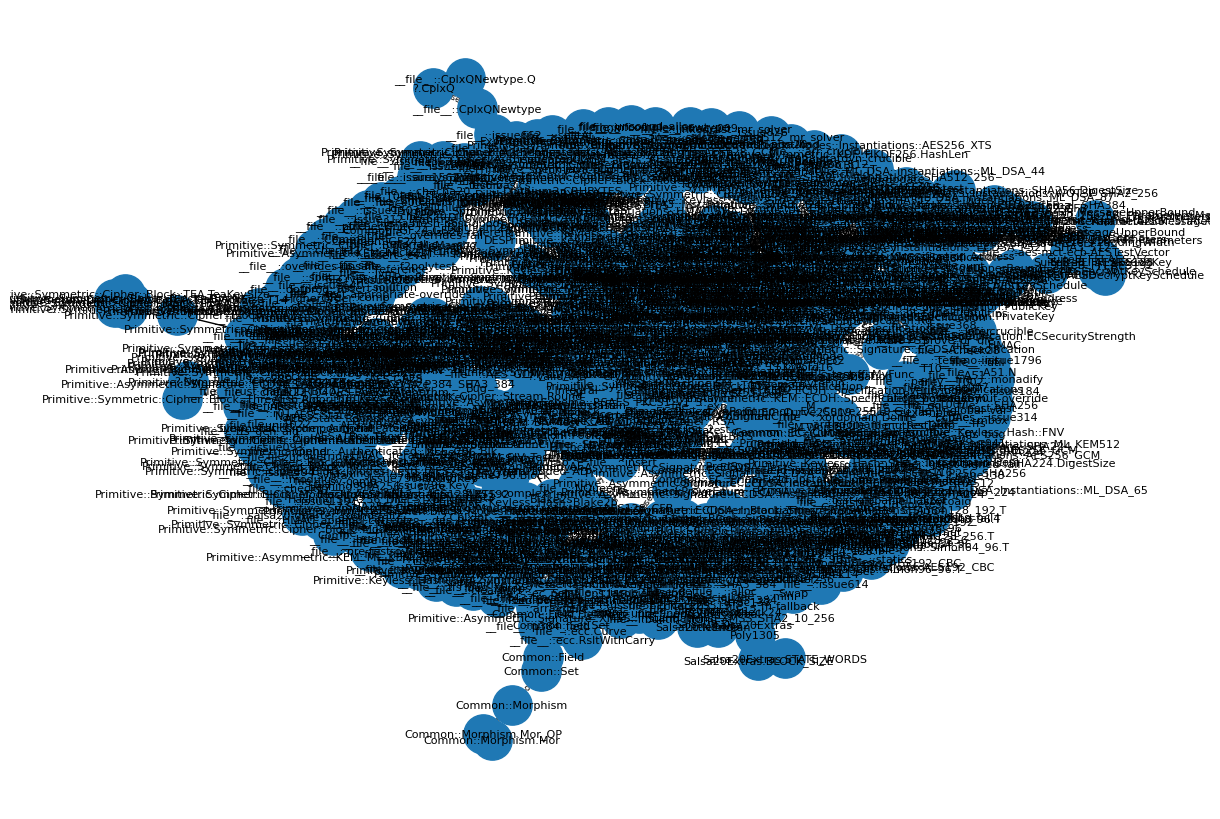

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, font_size=8, arrows=True)
edge_labels = nx.get_edge_attributes(G, "rel")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.show()


In [10]:
coverage = coverage_report_from_df(G=G, df=training_df)
print(f"{coverage["missing_modules_in_training"]}\n{len(coverage["missing_modules_in_training"])}")

['AES::SubByteSBox', 'CfrgCurves', 'Cipher', 'Common::AES_GCM_SIV', 'Common::ByteArray', 'Common::EC::PrimeField::Instantiations::P192', 'Common::EC::PrimeField::Instantiations::P224', 'Common::EC::PrimeField::Instantiations::P256', 'DRBG', 'Field', 'Id', 'Poly1305', 'Primitive::Keyless::Hash::SHA2Internal::SHA256', 'Primitive::Keyless::Hash::SHA2Internal::SHA384', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_224', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_256', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_384', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_512', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHAKE256', 'Primitive::Symmetric::Cipher::Block::AES::Instantiations::AES128', 'Primitive::Symmetric::Cipher::Block::AES::Instantiations::AES192', 'Primitive::Symmetric::Cipher::Block::AES::Instantiations::AES256', 'Primitive::Symmetric::Cipher::Block::Speck::Instantiations::Speck128_128', 'Primitive::Symmetric::Cipher::Block::Speck::Instant

In [ ]:
dropped_files_modules = []
for row in dropped_files.itertuples():
    modules = extract_module_name(row.content)
    if modules:
        dropped_files_modules.append({row.filename : modules})
        

In [20]:
missing_imports_from_dropped = [x for x in coverage["missing_modules_in_training"] if any(x in vals for d in dropped_files_modules for vals in d.values())]
missing_imports_not_found = [x for x in coverage["missing_modules_in_training"] if not any(x in vals for d in dropped_files_modules for vals in d.values())]

print(f"found: {missing_imports_from_dropped}\nlost: {missing_imports_not_found}")

found: ['AES::SubByteSBox', 'Cipher', 'Common::AES_GCM_SIV', 'Common::ByteArray', 'Common::EC::PrimeField::Instantiations::P192', 'Common::EC::PrimeField::Instantiations::P224', 'Common::EC::PrimeField::Instantiations::P256', 'DRBG', 'Field', 'Id', 'Primitive::Keyless::Hash::SHA2Internal::SHA256', 'Primitive::Keyless::Hash::SHA2Internal::SHA384', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_224', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_256', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_384', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHA3_512', 'Primitive::Keyless::Hash::SHA3::Instantiations::SHAKE256', 'Primitive::Symmetric::Cipher::Block::AES::Instantiations::AES128', 'Primitive::Symmetric::Cipher::Block::AES::Instantiations::AES192', 'Primitive::Symmetric::Cipher::Block::AES::Instantiations::AES256', 'Primitive::Symmetric::Cipher::Block::Speck::Instantiations::Speck128_128', 'Primitive::Symmetric::Cipher::Block::Speck::Instantiations::Speck128_1

In [23]:
files_to_put_back = []
for dict in dropped_files_modules:
    missing_found = [x for x in dict.values() if x in missing_imports_from_dropped]
    if len(missing_found) > 0:
        files_to_put_back.append(dict )

print(files_to_put_back)

[{'cryptol/examples/Cipher.cry': 'Cipher'}, {'cryptol/tests/modsys/functors/T012_M.cry': 'T012_M'}, {'cryptol/examples/param_modules/Common/AES_GCM_SIV.cry': 'Common::AES_GCM_SIV'}, {'cryptol/examples/param_modules/AES/SubByteSBox.cry': 'AES::SubByteSBox'}, {'cryptol/cryptol-remote-api/python/tests/cryptol/test-files/Id.cry': 'Id'}, {'cryptol-specs/Common/ByteArray.cry': 'Common::ByteArray'}, {'cryptol-specs/Primitive/Symmetric/Cipher/Block/Speck/Instantiations/Speck48_96.cry': 'Primitive::Symmetric::Cipher::Block::Speck::Instantiations::Speck48_96'}, {'cryptol-specs/Primitive/Symmetric/Cipher/Block/Speck/Instantiations/Speck32_64.cry': 'Primitive::Symmetric::Cipher::Block::Speck::Instantiations::Speck32_64'}, {'cryptol-specs/Primitive/Symmetric/Cipher/Block/Speck/Instantiations/Speck128_128.cry': 'Primitive::Symmetric::Cipher::Block::Speck::Instantiations::Speck128_128'}, {'cryptol-specs/Primitive/Symmetric/Cipher/Block/Speck/Instantiations/Speck64_96.cry': 'Primitive::Symmetric::Ciph

In [17]:
nocomments_deps = pd.read_json("data/training_datasets/syntax_check/nocomments.jsonl", lines=True)
files_with_missing_deps = []
for row in nocomments_deps.itertuples():
    missing = [x for x in row.file_deps if x in missing_imports_not_found]
    if len(missing) > 0:
        files_with_missing_deps.append(row.filename)

print(files_with_missing_deps)

['cryptol/examples/MiniLock/prim/CryptoBox.cry', 'cryptol-specs/Primitive/Symmetric/Cipher/Block/Modes/TDES_CBC.cry', 'cryptol-specs/Primitive/Symmetric/Cipher/Block/Modes/TDES_CFB.cry', 'saw-script/intTests/test_ffi_verify_salsa/salsa.cry', 'saw-script/saw-python/tests/saw-in-progress/drbg/drbg-helpers.cry']
